In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os
import common
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam, lr_scheduler


In [2]:
# Reproducibility
common.set_seed(1)

In [3]:
# for GPU
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Configuration parameters
layer_type = 'lrt'  # 'bbb' or 'lrt'
activation_type = 'softplus'  # 'softplus' or 'relu'
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}
lr_start = 0.001
num_workers = 1
valid_size = 0.2
batch_size = 256
train_ens = 1
valid_ens = 1
beta_type = 0.1

net_type = 'alexnet'   # (lenet/alexnet)
dataset = 'cifar10'    # (mnist/cifar10/cifar100)

In [5]:
if dataset == 'mnist':
    transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
    ])
    inputs = 1
    outputs = 10
    trainset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
elif dataset == 'cifar10':
    transform = transforms.Compose([
                transforms.ToTensor(),
    ])
    inputs = 3
    outputs = 10
    trainset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
elif dataset == 'cifar100':
    transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
    ])
    inputs = 3
    outputs = 100
    trainset = torchvision.datasets.CIFAR100(root='.', train=True, download=True, transform=transform)
else:
    raise RuntimeException("Unsupported dataset")
    
    
if net_type == 'lenet':
    net_class = common.non_bayesian_models.LeNet
    bbb_model = common.bayesian_models.BBBLeNet
elif net_type == 'alexnet':
    net_class = common.non_bayesian_models.AlexNet
    bbb_model = common.bayesian_models.BBBAlexNet
else:
    raise RuntimeException("Unsupported network type")
    
modelname = net_type + '-' + dataset + '.pt'
print(f'Sample model savename: {modelname}')

Files already downloaded and verified
Sample model savename: alexnet-cifar10.pt


In [6]:
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

In [7]:
net = bbb_model(outputs, inputs, priors, layer_type, activation_type).to(device)

In [8]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn.pt", force_train=False):
    if os.path.exists(modelname) and not force_train:
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = net_class(outputs, inputs, layer_type, activation_type).to(device)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [9]:
def load_models(K = 100):
    # Load the models
    sampled_models = [net_class(outputs, inputs, layer_type, activation_type) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load(modelname)):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

In [10]:
train_and_save_models(epochs = 20, K = 100, modelname = modelname, force_train=True)
sampled_models = load_models(K = 100)

Epoch:0, TrainLoss:37214447.376, TrainAcc:0.179, ValLoss:28585646.050, ValAcc:0.233, KL:366737852.943
Epoch:1, TrainLoss:24042108.076, TrainAcc:0.262, ValLoss:20316271.100, ValAcc:0.278, KL:239404641.223
Epoch:2, TrainLoss:17734307.382, TrainAcc:0.294, ValLoss:15486328.250, ValAcc:0.289, KL:176377470.981
Epoch:3, TrainLoss:13791453.299, TrainAcc:0.308, ValLoss:12273776.300, ValAcc:0.309, KL:136970470.981
Epoch:4, TrainLoss:11080202.414, TrainAcc:0.318, ValLoss:9991087.400, ValAcc:0.321, KL:109868375.389
Epoch:5, TrainLoss:9108910.627, TrainAcc:0.325, ValLoss:8293441.625, ValAcc:0.336, KL:90169811.159
Epoch:6, TrainLoss:7619969.105, TrainAcc:0.333, ValLoss:6991449.525, ValAcc:0.341, KL:75291111.694
Epoch:7, TrainLoss:6461548.570, TrainAcc:0.343, ValLoss:5966002.138, ValAcc:0.335, KL:63722204.484
Epoch:8, TrainLoss:5540408.242, TrainAcc:0.348, ValLoss:5139867.450, ValAcc:0.349, KL:54519595.949
Epoch:9, TrainLoss:4793156.268, TrainAcc:0.357, ValLoss:4464778.237, ValAcc:0.355, KL:47059217.

In [11]:
if dataset == 'mnist':
    transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
    ])
    inputs = 1
    outputs = 10
    testset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)
elif dataset == 'cifar10':
    transform = transforms.Compose([
                transforms.ToTensor(),
    ])
    inputs = 3
    outputs = 10
    testset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)
elif dataset == 'cifar100':
    transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
    ])
    inputs = 3
    outputs = 100
    testset = torchvision.datasets.CIFAR100(root='.', train=False, download=True, transform=transform)
else:
    raise RuntimeException("Unsupported dataset")
    
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, num_workers=num_workers)

Files already downloaded and verified


In [12]:
# Get a batch and flatten the input
images, targets = next(iter(test_loader))

In [13]:
targets

tensor([3])

In [14]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

In [15]:
def otcm(images, eps, saliency):
    return torch.clamp(images.clone()-eps*saliency, 0, 1)

In [16]:
# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, eps, saliency):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)
        # One step Target Class Method (OTCM); saliency is noise
        new_images = otcm(images, eps, saliency)
        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        # If we change the class, we fool the model
        fool += int(old_class != new_class)
    return fool/len(sampled_models)

In [17]:
# Collect noises (saliencies)
EPS = 0.18
saliencies = []
how_many_fooled = []
torch.set_printoptions(sci_mode=False)
for k in range(len(sampled_models)):
    # Forward pass
    # Compute loss w.r.t. an incorrect class
    # Note that we just have to ensure this class is different from targets
    images.grad = None
    images.requires_grad = True
    old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), torch.tensor([1])])
    # Compute adversarial example
    new_images = otcm(images, EPS, images.grad.sign())
    # Forward pass on adv. example
    new_class = forward_pass(sampled_models[k], new_images)
    if old_class != new_class:
        # How many models can this adv. example fool?
        how_many_fooled += [how_many_can_it_fool(sampled_models, EPS, images.grad.sign())]
        saliencies += [images.grad.sign().squeeze()]


In [18]:
# distributional saliency map
saliencies = torch.stack(saliencies)
print(saliencies.shape)
unbatched_shape = saliencies.shape[1:]
print(unbatched_shape)
newsaliency = torch.zeros(unbatched_shape)

if dataset == 'mnist':
    for i in range(unbatched_shape[0]):
        for j in range(unbatched_shape[1]):
            # choose median perturbation
            newsaliency[i, j] = np.percentile(saliencies[:, i, j].numpy(), 50)
else:
    for i in range(unbatched_shape[0]):
        for j in range(unbatched_shape[1]):
            for k in range(unbatched_shape[2]):
                # choose median perturbation
                newsaliency[i, j,k] = np.percentile(saliencies[:, i, j,k].numpy(), 50)

torch.Size([98, 3, 32, 32])
torch.Size([3, 32, 32])


In [19]:
print(how_many_can_it_fool(sampled_models, EPS, newsaliency))
new_images = otcm(images, EPS, newsaliency)

0.98


In [20]:
np.mean(how_many_fooled)

0.9792857142857144

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


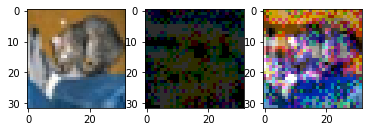

In [21]:
if dataset != 'mnist':
    # cifar datasets have color channels, need to arrange color channels
    images_prepped = np.transpose( images.squeeze().detach().numpy() , (1,2,0)) # squeeze out batch dimension and arrange color channels
    perturbation = newsaliency * EPS
    perturbation_prepped = np.transpose(perturbation.detach().numpy(), (1,2,0))
    new_images_prepped = np.transpose( new_images.squeeze().detach().numpy(), (1,2,0))
else:
    images_prepped = images.squeeze().detach().numpy()
    perturbation = newsaliency * EPS
    perturbation_prepped = perturbation.squeeze().detach().numpy()
    new_images_prepped = new_images.squeeze().detach().numpy()
    

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images_prepped)
plt.subplot(1, 3, 2)
plt.imshow(perturbation_prepped, vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(new_images_prepped)
plt.show()